### Importing required libraries such as numpy, tfds, tf to perform numerical operations, fetching datasets etc. 

In [1]:
# Importing the NumPy library for numerical operations
import numpy as np

# Importing TensorFlow Datasets (tfds) for easy access to standard datasets
import tensorflow_datasets as tfds

# Importing TensorFlow for building and training machine learning models
import tensorflow as tf

# Disabling the progress bar that is displayed during TensorFlow Datasets operations
tfds.disable_progress_bar()

### Writing a function to track the improvement in the training and validation metrics as number of Epochs increase

In [2]:
# Importing the pyplot module from matplotlib for creating visualizations
import matplotlib.pyplot as plt

# Define a function to plot the training and validation metrics
def plot_graphs(history, metric):
    # Plot the training metric values from the history object
    plt.plot(history.history[metric])
    
    # Plot the validation metric values from the history object
    plt.plot(history.history['val_'+metric], '')
    
    # Label the x-axis as "Epochs"
    plt.xlabel("Epochs")
    
    # Label the y-axis with the name of the metric
    plt.ylabel(metric)
    
    # Add a legend to differentiate between the training and validation metrics
    plt.legend([metric, 'val_'+metric])


### We are using IMDB reviews dataset from Tensorflow datasets library. below code imports the dataset and shows an example

In [3]:
# Load the IMDb reviews dataset from TensorFlow Datasets
# - `with_info=True` includes dataset metadata
# - `as_supervised=True` returns the dataset i/n a (input, label) tuple format
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Split the dataset into training and testing sets
train_dataset, test_dataset = dataset['train'], dataset['test']

# Display the structure of the elements in the training dataset
# This shows the data type and shape of the input and label tensors
display(train_dataset.element_spec)

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [4]:
# Set the buffer size for shuffling the dataset
# Larger buffer size results in better shuffling but requires more memory
BUFFER_SIZE = 10000

# Set the batch size for processing the data
# Each batch will contain this number of examples
BATCH_SIZE = 64

# Prepare the training dataset:
# - Shuffle the dataset with the specified buffer size to randomize the order of examples
# - Batch the dataset into chunks of the specified batch size
# - Prefetch data to improve performance by loading the next batch while the current batch is being processed
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Prepare the test dataset:
# - Batch the dataset into chunks of the specified batch size
# - Prefetch data to improve performance by loading the next batch while the current batch is being processed
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Iterate through the training dataset and take the first batch for inspection
# - `example` contains the input text data
# - `label` contains the corresponding labels
for example, label in train_dataset.take(1):
    # Print the first three examples from the batch
    # Convert tensors to numpy arrays for easier inspection
    print('texts: ', example.numpy()[:3])
    
    # Print an empty line for separation
    print()
    
    # Print the first three labels from the batch
    # Convert tensors to numpy arrays for easier inspection
    print('labels: ', label.numpy()[:3])

texts:  [b'I am an actor,producer, director and what i am about to say are facts. This project was the worst film in movie making history. From producer to director and the edit of this so called film is a joke and i mean a BIG joke. Why would Blockbuster released such crap? I take my work very serious and this film is an insult to my profession. Was the director trying to make a bad movie? I don\'t think so. I seen bad Zombie movies, but this takes the cake the Coffie and everything on the damn table. THIS MOVIE SUCKS!!! I really hate to talk bad about other filmmakers because i am one myself, but please consider in taking up a different profession. I respect the fact that you completed a movie, but i have to ask you " WERE YOU SMOKING CRACK ", I mean the makeup on your girls, the scary Zombies, what were you thinking. To the whole nation, if i could have voted Zero i would have. WORST FILM IN MOVIE MAKING HISTORY!!!'
 b'After Garbo\'s introduction to sound in Clarence Brown\'s "Anna 

In [5]:
# Define the maximum vocabulary size for the TextVectorization layer
# This determines the number of unique tokens the encoder will consider
VOCAB_SIZE = 1000

# Initialize a TextVectorization layer with a maximum of VOCAB_SIZE unique tokens
# This layer will convert text data into integer sequences based on the vocabulary
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Fit the TextVectorization layer to the training dataset
# This process builds the vocabulary from the text data in the training set
# The lambda function extracts only the text part from the (text, label) tuple
# The `.adapt` method creates the vocabulary for the layer. Here are the first 20 tokens in the vocabulary. 
# After accounting for padding and unknown tokens, these tokens are listed in order of how frequently they appear.

encoder.adapt(train_dataset.map(lambda text, label: text))

# Retrieve the vocabulary as a NumPy array
# This contains the words (tokens) corresponding to the integer indices
vocab = np.array(encoder.get_vocabulary())

# Display the first 20 words in the vocabulary
# These are the most frequent tokens found in the training data
display('First 20 words in the vocabulary: ', vocab[:20])

# Encode the first 3 examples from the batch using the TextVectorization layer
# This converts the text data into sequences of integer indices based on the vocabulary
encoded_example = encoder(example)[:3].numpy()

# Display the encoded integer sequences for the first 3 examples
display(encoded_example)


# Print the original text and its round-trip encoding for the first 3 examples
for n in range(3):
    # Print the original text example
    print("Original: ", example[n].numpy())
    
    # Convert the encoded integer sequence back to text using the vocabulary
    # The vocabulary array maps integer indices back to words
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    
    # Print an empty line for separation
    print()


'First 20 words in the vocabulary: '

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

array([[ 10, 237,  34, ...,   0,   0,   0],
       [101,   1,   1, ...,   0,   0,   0],
       [ 10,  41, 208, ...,   0,   0,   0]])

Original:  b'I am an actor,producer, director and what i am about to say are facts. This project was the worst film in movie making history. From producer to director and the edit of this so called film is a joke and i mean a BIG joke. Why would Blockbuster released such crap? I take my work very serious and this film is an insult to my profession. Was the director trying to make a bad movie? I don\'t think so. I seen bad Zombie movies, but this takes the cake the Coffie and everything on the damn table. THIS MOVIE SUCKS!!! I really hate to talk bad about other filmmakers because i am one myself, but please consider in taking up a different profession. I respect the fact that you completed a movie, but i have to ask you " WERE YOU SMOKING CRACK ", I mean the makeup on your girls, the scary Zombies, what were you thinking. To the whole nation, if i could have voted Zero i would have. WORST FILM IN MOVIE MAKING HISTORY!!!'
Round-trip:  i am an [UNK] director and what i am about to say ar

## Model

- **Model Structure**: 
  - Built using `tf.keras.Sequential`.

- **First Layer**:
  - **Encoder**: Transforms text into a sequence of token indices.

- **Second Layer**:
  - **Embedding Layer**: Converts token indices into trainable vectors. Similar words end up with similar vectors, which is more efficient than using one-hot encoding with a `Dense` layer.

- **Third Layer**:
  - **Recurrent Neural Network (RNN)**: Processes the sequence by iterating through elements, passing outputs from one timestep to the next. 
  - **Bidirectional RNN**: Can process the input in both directions (forward and backward), helping to capture information from both ends of the sequence. However, it’s less efficient for streaming predictions.

- **Final Layers**:
  - **Dense Layers**: Perform final processing to convert the sequence vector into a single logit for classification.

In [6]:
# Build a Sequential model using TensorFlow Keras
model = tf.keras.Sequential([
    # Encoder layer to convert text to token indices
    encoder,
    
    # Embedding layer to convert token indices to dense vectors
    # - input_dim: Size of the vocabulary (number of unique tokens)
    # - output_dim: Dimension of the dense embedding vectors
    # - mask_zero: Allows the layer to handle variable-length sequences by masking zeros
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Size of the vocabulary
        output_dim=64,  # Dimension of the embedding vectors
        mask_zero=True  # Enable masking for variable-length sequences
    ),
    
    # Bidirectional LSTM layer processes sequences in both forward and backward directions
    # - LSTM units: 64
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    # Dense layer with ReLU activation for additional processing
    # - Units: 64
    tf.keras.layers.Dense(64, activation='relu'),
    
    # Final Dense layer for producing the output
    # - Units: 1 (e.g., for binary classification or regression)
    tf.keras.layers.Dense(1)
])

#### Masking & Padding usage in the model

In [7]:
##### Padding standardizes sequence lengths by adding extra values.
##### Masking allows the model to ignore these padding values during processing.

# Check which layers in the model support masking
# This helps determine if the model can properly handle padded sequences
print([layer.supports_masking for layer in model.layers])

# Predict on a sample text without padding
# Sample text is a straightforward example for model prediction
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
# Convert the sample text into a NumPy array and ensure the type is 'object'
# `astype(object)` is used to handle the text data correctly
predictions = model.predict(np.array([sample_text]).astype(object))
# Print the prediction for the sample text
print(predictions[0])

# Predict on a sample text with padding
# Create a long padding string to simulate a sequence with extra length
padding = "the " * 2000
# Predict on both the sample text and the padded text
# Convert both texts into a NumPy array and ensure the type is 'object'
predictions = model.predict(np.array([sample_text, padding]).astype(object))
# Print the prediction for the sample text (only the first prediction)
print(predictions[0])

[False, True, True, True, True]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.01250756]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
[0.01250756]


In [8]:
#### compiling the model 

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Training the model

In [9]:
# Train the model using the training dataset and validate with the test dataset
# - `train_dataset`: The dataset used for training the model
# - `epochs=10`: The number of epochs to train the model
# - `validation_data=test_dataset`: The dataset used for validating the model during training
# - `validation_steps=30`: The number of steps (batches) to draw from the validation dataset for evaluation

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.5168 - loss: 0.6820 - val_accuracy: 0.5469 - val_loss: 0.6266
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.7077 - loss: 0.5094 - val_accuracy: 0.8474 - val_loss: 0.3525
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.8388 - loss: 0.3593 - val_accuracy: 0.8568 - val_loss: 0.3106
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8576 - loss: 0.3274 - val_accuracy: 0.8406 - val_loss: 0.3454
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8620 - loss: 0.3151 - val_accuracy: 0.8635 - val_loss: 0.3206
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8662 - loss: 0.3155 - val_accuracy: 0.8531 - val_loss: 0.3345
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8714 - loss: 0.3013 - val_accuracy: 0.8667 - val_loss: 0.3033
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8695 - loss: 0.2997 - 

In [10]:
# Evaluate the model on the test dataset
# - `test_dataset`: The dataset used for testing the model's performance
# The method returns the loss value and metrics specified during model compilation (e.g., accuracy)
test_loss, test_acc = model.evaluate(test_dataset)

# Print the loss value obtained on the test dataset
# This represents how well the model performed on the test data, with lower values indicating better performance
print('Test Loss:', test_loss)

# Print the accuracy value obtained on the test dataset
# This represents the proportion of correct predictions made by the model on the test data
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8618 - loss: 0.3128
Test Loss: 0.3130829632282257
Test Accuracy: 0.8595200181007385


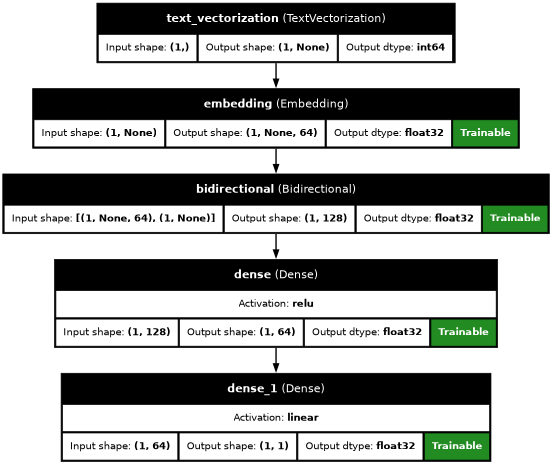

In [11]:
# Import the `plot_model` function from TensorFlow Keras utilities
from tensorflow.keras.utils import plot_model

# Generate and save a visual representation of the model architecture
plot_model(model,
            # Show the shapes of the layers' outputs in the diagram
            show_shapes=True,
            # Display the data types of the layers in the diagram
            show_dtype=True,
            # Show the names of the layers in the diagram
            show_layer_names=True,
            # Set the direction of the plot: 'TB' means top-to-bottom
            rankdir='TB',
            # Expand nested models (models within models) in the diagram
            expand_nested=True,
            # Set the resolution of the image
            dpi=50,
            # Display the activation functions used in the layers
            show_layer_activations=True,
            # Indicate which layers are trainable in the diagram
            show_trainable=True)

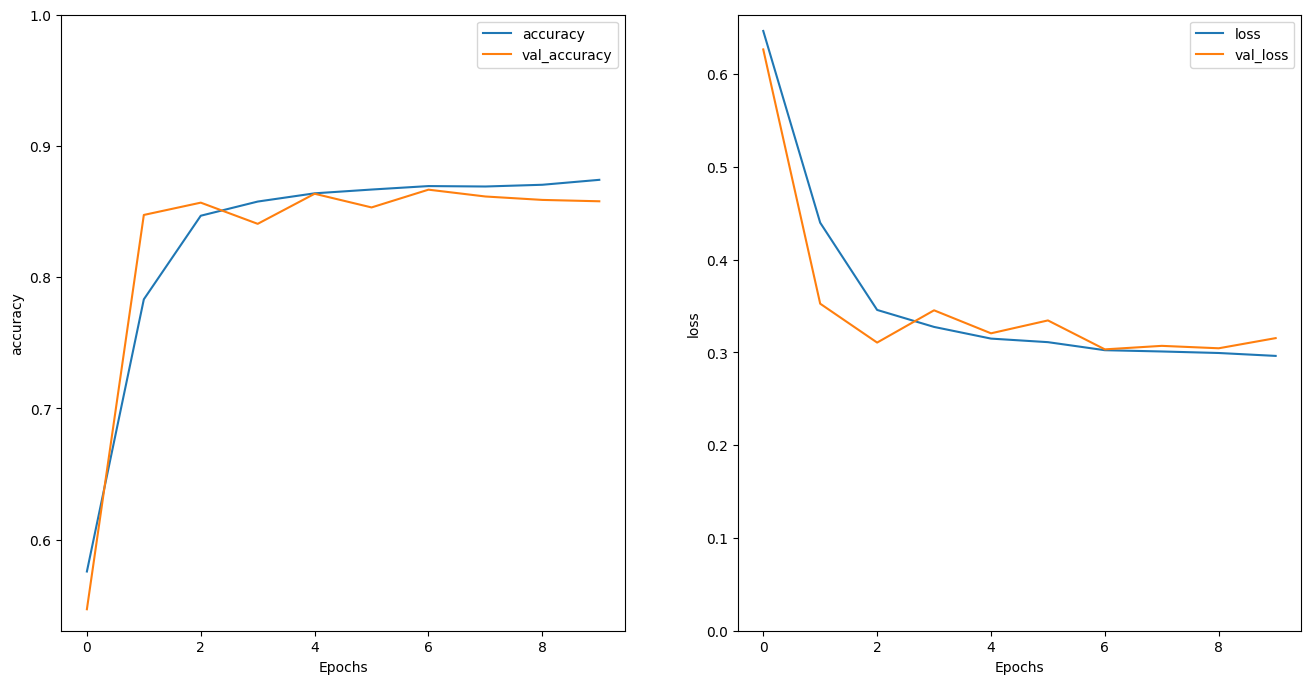

In [12]:
# Create a new figure for plotting with a specified size (16 inches wide by 8 inches tall)
plt.figure(figsize=(16, 8))

# Create the first subplot in a 1x2 grid (1 row, 2 columns), focusing on the left side
plt.subplot(1, 2, 1)

# Plot the graphs for the 'accuracy' metric using the custom `plot_graphs` function
# This visualizes the training and validation accuracy over epochs
plot_graphs(history, 'accuracy')

# Set the y-axis limits for the accuracy plot
# `None` for the lower limit means it will be automatically adjusted
# `1` as the upper limit ensures the accuracy is shown up to 100%
plt.ylim(None, 1)

# Create the second subplot in the same 1x2 grid, focusing on the right side
plt.subplot(1, 2, 2)

# Plot the graphs for the 'loss' metric using the custom `plot_graphs` function
# This visualizes the training and validation loss over epochs
plot_graphs(history, 'loss')

# Set the y-axis limits for the loss plot
# `0` as the lower limit ensures the loss starts from zero
# `None` for the upper limit means it will be automatically adjusted
plt.ylim(0, None)

# Display the figure with both subplots
plt.show()

In [13]:
# Define a sample text input for prediction
# This string will be used to test the model's performance
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert the sample text into a NumPy array
# The `np.array([sample_text])` converts the string into a single-element array
# The `astype(object)` ensures that the data type is 'object', which is suitable for text data
# This is necessary because Keras models expect input data in array format
predictions = model.predict(np.array([sample_text]).astype(object))

# Output the predictions made by the model for the provided sample text
# `model.predict()` returns the model's predictions for the given input
# The result is stored in the `predictions` variable, which may be a probability or logit, depending on the model
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


array([[0.7223988]], dtype=float32)

## Stacking Two or More LSTM Layers

- **`return_sequences=False`**: 
  - Returns only the final output for each sequence.
  - Results in a 2D tensor with shape `(batch_size, output_features)`.
  - This is the default setting.

- **`return_sequences=True`**: 
  - Returns the output for each timestep throughout the entire sequence.
  - Results in a 3D tensor with shape `(batch_size, timesteps, output_features)`.

- **Information Flow with `return_sequences=True`**: 
  - The output is provided for every timestep in the sequence, not just the final one.

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [14]:
# Define a Sequential model in Keras
# This model is composed of a series of layers applied one after another

model = tf.keras.Sequential([
    # Encoder layer for processing text data
    # Converts input text into a sequence of token indices
    encoder,
    
    # Embedding layer for converting token indices into dense vectors
    # `len(encoder.get_vocabulary())` specifies the size of the vocabulary (input_dim)
    # `64` specifies the size of the dense vectors (output_dim)
    # `mask_zero=True` allows the layer to ignore padding tokens (zeros) during training
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    
    # First LSTM layer with bidirectional processing
    # `64` units in the LSTM cell
    # `return_sequences=True` ensures that the output includes the sequence for each timestep, not just the final output
    # Bidirectional wrapper allows the LSTM to process the input in both forward and backward directions
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    
    # Second LSTM layer with bidirectional processing
    # `64` units in the LSTM cell
    # Since `return_sequences` is not specified, it defaults to `False`, providing only the final output of the sequence
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    # Dense layer for additional processing
    # `64` units with ReLU activation function to introduce non-linearity and learn complex patterns
    tf.keras.layers.Dense(64, activation='relu'),
    
    # Dropout layer for regularization
    # `0.5` dropout rate means 50% of the neurons are randomly set to zero during training to prevent overfitting
    tf.keras.layers.Dropout(0.5),
    
    # Output layer for the final prediction
    # `1` unit for binary classification
    # No activation function specified, as the output will be processed by the loss function
    tf.keras.layers.Dense(1)
])

# Compile the model with the specified settings
model.compile(
    # Loss function for binary classification
    # BinaryCrossentropy calculates the loss between true and predicted labels
    # `from_logits=True` indicates that the model outputs raw logits, not probabilities
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    
    # Optimizer used to update model weights
    # Adam optimizer with a learning rate of 0.0001 (1e-4)
    optimizer=tf.keras.optimizers.Adam(1e-4),
    
    # Metrics to evaluate model performance
    # `accuracy` measures the proportion of correct predictions
    metrics=['accuracy']
)

In [15]:
# Train the model using the training dataset and validate its performance with the test dataset
history = model.fit(
    # `train_dataset` is the dataset used to train the model
    # It contains input data and corresponding labels for training
    train_dataset,
    
    # `epochs=10` specifies the number of times the entire training dataset will be passed through the model
    # More epochs can improve training but also risk overfitting
    epochs=10,
    
    # `validation_data=test_dataset` specifies the dataset used to validate the model's performance
    # The model will evaluate its performance on this data at the end of each epoch
    validation_data=test_dataset,
    
    # `validation_steps=30` defines the number of batches to use from the `test_dataset` for validation
    # This controls how many steps the model will take to evaluate on the validation data each epoch
    validation_steps=30
)


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 53s 123ms/step - accuracy: 0.5371 - loss: 0.6626 - val_accuracy: 0.8281 - val_loss: 0.3967
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 122ms/step - accuracy: 0.8317 - loss: 0.3800 - val_accuracy: 0.8411 - val_loss: 0.3251
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 122ms/step - accuracy: 0.8541 - loss: 0.3340 - val_accuracy: 0.8792 - val_loss: 0.3132
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 122ms/step - accuracy: 0.8577 - loss: 0.3218 - val_accuracy: 0.8521 - val_loss: 0.3280
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 122ms/step - accuracy: 0.8598 - loss: 0.3196 - val_accuracy: 0.8552 - val_loss: 0.3148
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 122ms/step - accuracy: 0.8690 - loss: 0.3052 - val_accuracy: 0.7807 - val_loss: 0.4496
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - accuracy: 0.8581 - loss: 0.3169 - val_accuracy: 0.8682 - val_loss: 0.3121
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 122ms/step - accuracy: 0.8718 - loss: 0

In [16]:
# Evaluate the model's performance on the test dataset
# This calculates the loss and accuracy metrics using the `test_dataset`
test_loss, test_acc = model.evaluate(test_dataset)

# Print the test loss
# `test_loss` contains the loss value computed on the test dataset
# It indicates how well the model's predictions match the true labels
print('Test Loss:', test_loss)

# Print the test accuracy
# `test_acc` contains the accuracy value computed on the test dataset
# It represents the proportion of correct predictions made by the model
print('Test Accuracy:', test_acc)


391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.8555 - loss: 0.3211
Test Loss: 0.31931164860725403
Test Accuracy: 0.8550000190734863


In [17]:
# Define a sample text input for prediction
# This text will be used to test the model's prediction capabilities
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')

# Convert the sample text into a NumPy array
# `np.array([sample_text])` converts the single string into a one-element array
# `astype('object')` ensures that the data type of the array is 'object', which is suitable for text data
# This format is necessary for the model to process the input correctly
predictions = model.predict(np.array([sample_text]).astype('object'))

# Output the model's predictions for the provided sample text
# `model.predict()` returns the prediction made by the model
# The result is stored in the `predictions` variable, which may be a probability or logit depending on the model's configuration
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
[[-1.6821798]]


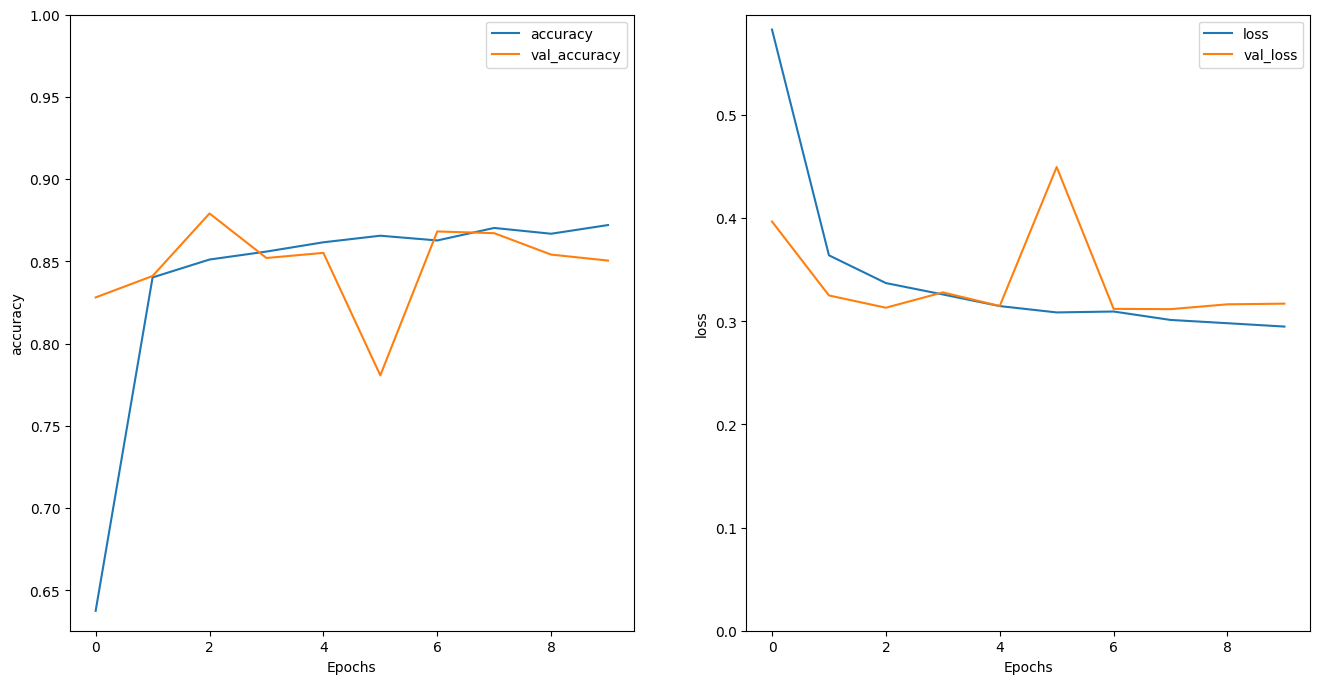

In [18]:
# Create a new figure for plotting with a specified size (16 inches wide by 8 inches tall)
plt.figure(figsize=(16, 8))

# Create the first subplot in a 1x2 grid (1 row, 2 columns), focusing on the left side
plt.subplot(1, 2, 1)

# Plot the graphs for the 'accuracy' metric using the custom `plot_graphs` function
# This visualizes the training and validation accuracy over epochs
plot_graphs(history, 'accuracy')

# Set the y-axis limits for the accuracy plot
# `None` for the lower limit means it will be automatically adjusted
# `1` as the upper limit ensures the accuracy is shown up to 100%
plt.ylim(None, 1)

# Create the second subplot in the same 1x2 grid, focusing on the right side
plt.subplot(1, 2, 2)

# Plot the graphs for the 'loss' metric using the custom `plot_graphs` function
# This visualizes the training and validation loss over epochs
plot_graphs(history, 'loss')

# Set the y-axis limits for the loss plot
# `0` as the lower limit ensures the loss starts from zero
# `None` for the upper limit means it will be automatically adjusted
plt.ylim(0, None)

# Display the figure with both subplots
plt.show()

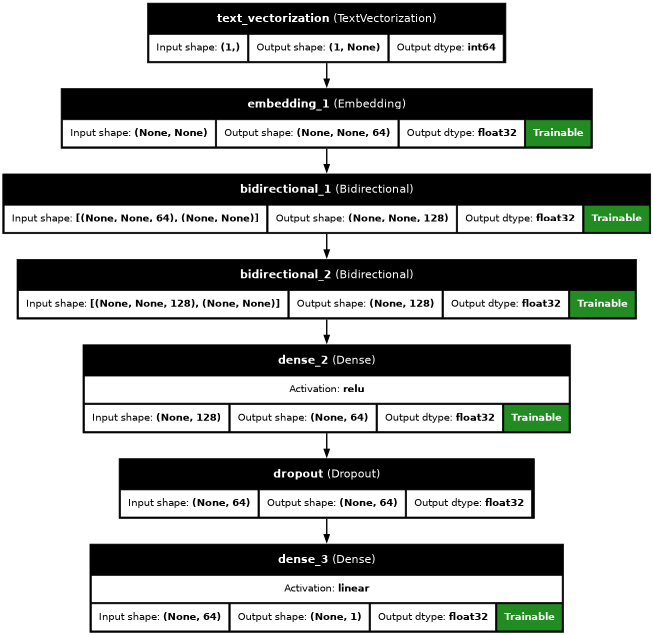

In [19]:
# Import the function to visualize the model architecture
from tensorflow.keras.utils import plot_model

# Generate a plot of the model architecture
plot_model(
    model,                      # The Keras model to visualize
    show_shapes=True,           # Display the shapes of the output tensors for each layer
    show_dtype=True,            # Display the data type of the output tensors for each layer
    show_layer_names=True,      # Display the names of the layers in the plot
    rankdir='TB',               # Set the direction of the plot: 'TB' means top-to-bottom
    expand_nested=True,         # Expand nested models into a single view if there are nested models
    dpi=50,                     # Set the resolution of the image (dots per inch)
    show_layer_activations=True, # Display activations in the layer details (if applicable)
    show_trainable=True         # Indicate which layers are trainable
)
